# Training on 13,231 events from ACTS. Testing on 3308 events from ACTS.

In [1]:
!nvidia-smi

Thu Aug 31 14:41:14 2017       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 375.66                 Driver Version: 375.66                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1080    Off  | 0000:04:00.0     Off |                  N/A |
| 27%   29C    P8     9W / 180W |   1812MiB /  8114MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 1080    Off  | 0000:05:00.0     Off |                  N/A |
| 27%   31C    P8     9W / 180W |   1303MiB /  8114MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "6"
%matplotlib notebook
import importlib
import numpy as np
import pandas as pd
import keras
import sys
from keras.layers import TimeDistributed, Dense, Dropout, GRU, Bidirectional
from keras.models import Sequential
from tracker import extractor as ext, utils, metrics, visuals

Using Theano backend.
Using cuDNN version 5110 on context None
Mapped name None to device cuda: GeForce GTX 1080 (0000:0D:00.0)


### Load in the data.

In [8]:
%%time
modelpath = "data/models/ACTS-10N-25T-260R.h5"
filepath  = "data/sets/ACTS-10N-25T-16539E-260R.gz"
frame     = pd.read_csv(filepath)
events    = [event for (_, event) in frame.groupby("event_id", sort=False)]
percent   = 0.8
cutoff    = int(percent * len(events))
train, test = events[:cutoff], events[cutoff:]
print("Train is list of {} events.".format(len(train)))
print("Test is list of {} events.".format(len(test)))
print("Train takes up {} bytes.".format(sys.getsizeof(train)))
print("Test takes up {} bytes.".format(sys.getsizeof(test)))
if (not utils.is_prepared(train[0])) or (not utils.is_prepared(test[0])):
    print("Warning: frame is not prepared.")
    print("Look at the prepare_frame() function in tracker/extractor.py")
else:
    del frame  
    del events  # To save on memory.

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 9.06 µs


In [4]:
order = ["phi", "r", "z"]

### Get an idea for how the tracks are distributed among the events.

In [ ]:
dist = metrics.distributions(pd.concat(train))
for i in range(len(dist[0])):
    print("There are {0} events with {1} tracks.".format(dist[1][i], dist[0][i]))

In [ ]:
dist = metrics.distributions(pd.concat(test))
for i in range(len(dist[0])):
    print("There are {0} events with {1} tracks.".format(dist[1][i], dist[0][i]))

### Show an example of the data.

Train 12411
Number of Hits: 148
Number of Tracks: 24


<IPython.core.display.Javascript object>


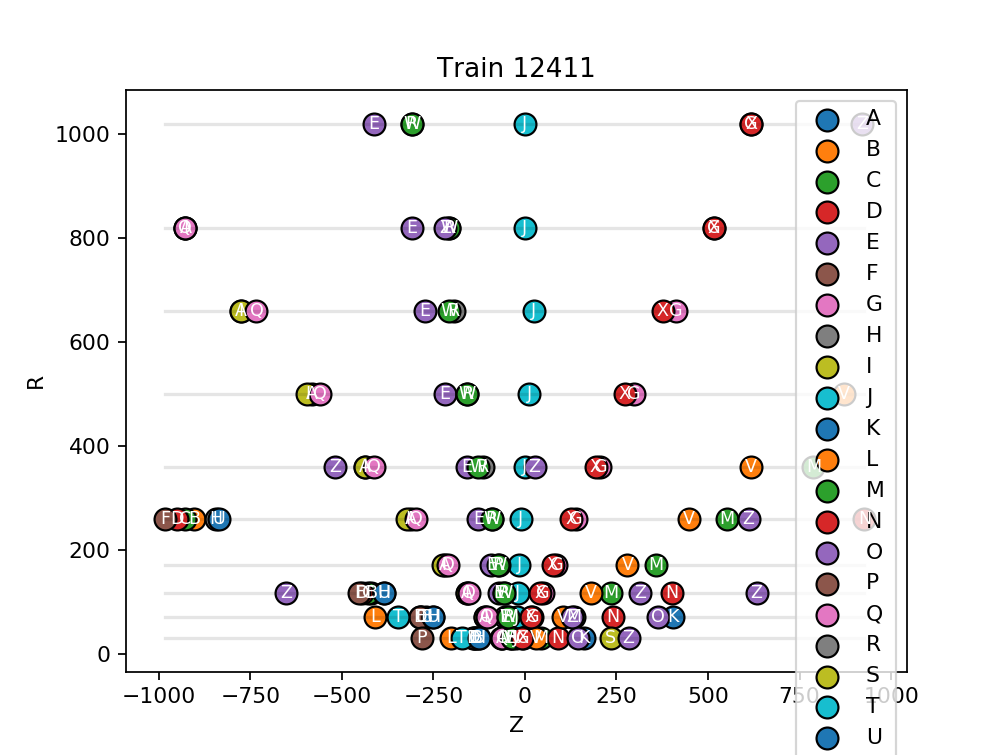

<IPython.core.display.Javascript object>


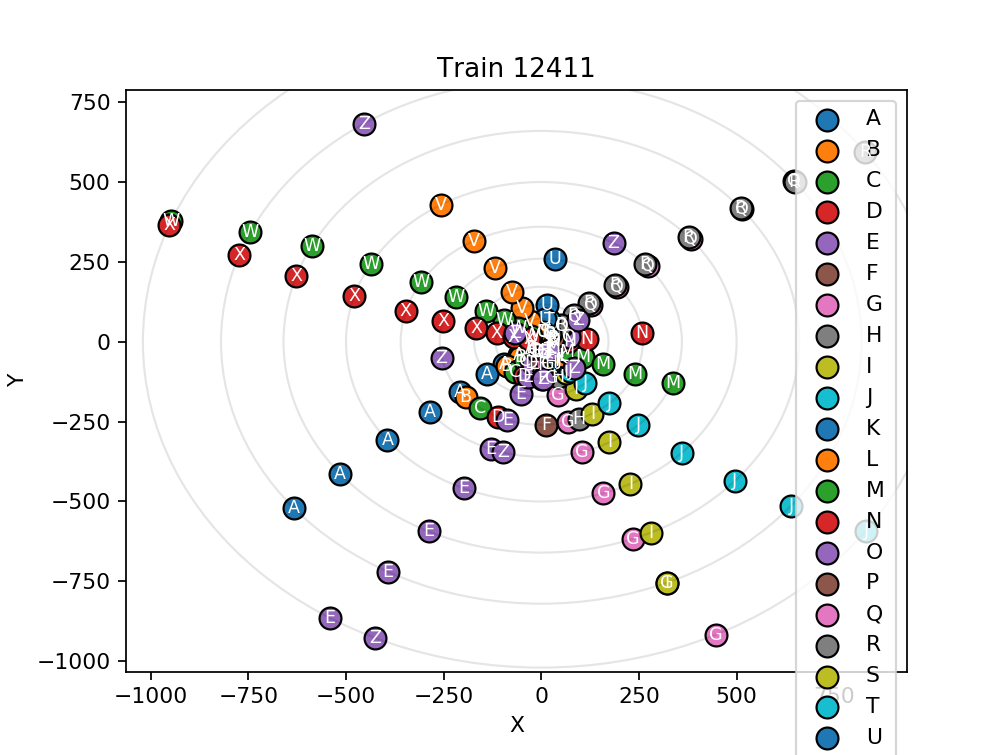

In [5]:
n = np.random.randint(len(train))
print("Train {}".format(n))
print("Number of Hits: {}".format(metrics.number_of_hits(train[n])))
print("Number of Tracks: {}".format(metrics.number_of_tracks(train[n])))
visuals.Plot2D(train[n], order).plot(mode="zr", title="Train {}".format(n))
visuals.Plot2D(train[n], order).plot(mode="xy", title="Train {}".format(n))

In [6]:
visuals.display(train[n], order)

,phi,r,z,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,Y,noise,pad
0,-2.947734,260.0,610.907603,,,,,,,,,,,,,,,,,,,,,,,,,,1,
1,-2.513200,32.0,-63.378100,1,,,,,,,,,,,,,,,,,,,,,,,,,,
2,-2.510717,72.0,-108.583000,1,,,,,,,,,,,,,,,,,,,,,,,,,,
3,-2.507448,117.0,-158.257000,1,,,,,,,,,,,,,,,,,,,,,,,,,,
4,-2.503419,172.0,-218.984000,1,,,,,,,,,,,,,,,,,,,,,,,,,,
5,-2.496925,260.0,-310.458000,1,,,,,,,,,,,,,,,,,,,,,,,,,,
6,-2.488873,360.0,-436.000000,1,,,,,,,,,,,,,,,,,,,,,,,,,,
7,-2.478577,500.0,-582.000000,1,,,,,,,,,,,,,,,,,,,,,,,,,,
8,-2.466126,660.0,-776.000000,1,,,,,,,,,,,,,,,,,,,,,,,,,,
9,-2.454660,820.0,-927.000000,1,,,,,,,,,,,,,,,,,,,,,,,,,,


### Create the model.

In [11]:
input_shape  = (260, 3)
n_categories = 25 + 2
optimizer    = keras.optimizers.RMSprop(lr=0.001)
histories    = []

In [ ]:
model = keras.models.load_model(modelpath)

In [12]:
model = Sequential()
model.add(Bidirectional(
    GRU(units=256, return_sequences=True, recurrent_dropout=1/2, implementation=2),
    merge_mode="mul",
    input_shape=input_shape))
model.add(Dropout(rate=1/2))
model.add(Bidirectional(
    GRU(units=256, return_sequences=True, recurrent_dropout=1/2, implementation=2),
    merge_mode="mul"))
model.add(Dropout(rate=1/2))
model.add(Bidirectional(
    GRU(units=256, return_sequences=True, recurrent_dropout=1/2, implementation=2),
    merge_mode="mul"))
model.add(Dropout(rate=1/2))
model.add(TimeDistributed(Dense(units=n_categories, kernel_initializer="uniform", activation="softmax")))
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_4 (Bidirection (None, 260, 256)          399360    
_________________________________________________________________
dropout_4 (Dropout)          (None, 260, 256)          0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 260, 256)          787968    
_________________________________________________________________
dropout_5 (Dropout)          (None, 260, 256)          0         
_________________________________________________________________
bidirectional_6 (Bidirection (None, 260, 256)          787968    
_________________________________________________________________
dropout_6 (Dropout)          (None, 260, 256)          0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 260, 27)           6939      
Total para

### Fit the model.

In [13]:
%%time
# 128 + 32
epochs     = 128
batch_size = 100
histories.append(model.fit_generator(
    ext.input_output_generator(train, batch_size, order),
    steps_per_epoch=len(train) // batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=ext.input_output_generator(test, batch_size, order),
    validation_steps=len(test) // batch_size,
    callbacks=[
        keras.callbacks.ModelCheckpoint(
            filepath=modelpath,
            save_best_only=True,
            verbose=0,),
        keras.callbacks.EarlyStopping(patience=10, verbose=1),
        keras.callbacks.ReduceLROnPlateau(patience=5, verbose=1)]))

Epoch 1/128
132/132 [==============================] - 216s - loss: 1.2826 - acc: 0.6728 - val_loss: 0.8082 - val_acc: 0.7095
Epoch 2/128
132/132 [==============================] - 206s - loss: 0.8238 - acc: 0.7139 - val_loss: 0.7354 - val_acc: 0.7303
Epoch 3/128
132/132 [==============================] - 205s - loss: 0.7587 - acc: 0.7268 - val_loss: 0.7425 - val_acc: 0.7211
Epoch 4/128
132/132 [==============================] - 206s - loss: 0.7165 - acc: 0.7374 - val_loss: 0.6920 - val_acc: 0.7351
Epoch 5/128
132/132 [==============================] - 207s - loss: 0.6810 - acc: 0.7461 - val_loss: 0.5870 - val_acc: 0.7779
Epoch 6/128
132/132 [==============================] - 207s - loss: 0.6534 - acc: 0.7543 - val_loss: 0.5996 - val_acc: 0.7638
Epoch 7/128
132/132 [==============================] - 205s - loss: 0.6246 - acc: 0.7644 - val_loss: 0.5200 - val_acc: 0.8035
Epoch 8/128
132/132 [==============================] - 208s - loss: 0.5973 - acc: 0.7719 - val_loss: 0.5451 - val_acc:

132/132 [==============================] - 202s - loss: 0.2573 - acc: 0.9106 - val_loss: 0.2096 - val_acc: 0.9248
Epoch 65/128
132/132 [==============================] - 202s - loss: 0.2513 - acc: 0.9131 - val_loss: 0.2097 - val_acc: 0.9256
Epoch 66/128
132/132 [==============================] - 202s - loss: 0.2524 - acc: 0.9131 - val_loss: 0.2101 - val_acc: 0.9256
Epoch 67/128
132/132 [==============================] - 201s - loss: 0.2477 - acc: 0.9142 - val_loss: 0.2085 - val_acc: 0.9265
Epoch 68/128
132/132 [==============================] - 201s - loss: 0.2480 - acc: 0.9146 - val_loss: 0.2070 - val_acc: 0.9265
Epoch 69/128
132/132 [==============================] - 201s - loss: 0.2444 - acc: 0.9157 - val_loss: 0.2070 - val_acc: 0.9264
Epoch 70/128
132/132 [==============================] - 201s - loss: 0.2464 - acc: 0.9151 - val_loss: 0.2062 - val_acc: 0.9264
Epoch 71/128
132/132 [==============================] - 201s - loss: 0.2455 - acc: 0.9147 - val_loss: 0.2062 - val_acc: 0.92

132/132 [==============================] - 202s - loss: 0.2301 - acc: 0.9208 - val_loss: 0.1964 - val_acc: 0.9308
Epoch 127/128
131/132 [============================>.] - ETA: 1s - loss: 0.2287 - acc: 0.9215
Epoch 00126: reducing learning rate to 1.0000001111620805e-07.
132/132 [==============================] - 201s - loss: 0.2287 - acc: 0.9215 - val_loss: 0.1964 - val_acc: 0.9308
Epoch 00126: early stopping
CPU times: user 7h 15min 41s, sys: 9min 5s, total: 7h 24min 46s
Wall time: 7h 11min 26s


### Display information about the model after fitting it.

In [14]:
%%time
guesses          = model.predict(ext.extract_input(test, order))
hits_correct     = metrics.percent_of_hits_assigned_correctly(test, guesses=guesses, order=order)
tracks_correct   = metrics.percent_of_tracks_assigned_correctly(test, guesses=guesses, order=order, percent=1.0)
n_tracks_correct = metrics.percent_of_events_with_correct_number_of_tracks(test, guesses=guesses, order=order)
print("Percent of hits assigned correctly: {}%".format(hits_correct * 100))
print("Percent of tracks assigned correctly: {}%".format(tracks_correct * 100))
print("Percent of events with the correct number of tracks: {}%".format(n_tracks_correct * 100))

Percent of hits assigned correctly: 82.0764213724261%
Percent of tracks assigned correctly: 70.88502894954509%
Percent of events with the correct number of tracks: 70.13301088270859%
CPU times: user 1min 17s, sys: 116 ms, total: 1min 17s
Wall time: 1min 17s


### Display how one of the model's predictions looks.

In [ ]:
n  = 3138  # np.random.randint(len(test))
print("Percent of hits assigned correctly: {}%".format(
    metrics.percent_of_hits_assigned_correctly(test[n], guesses[n], order) * 100))
print("Percent of tracks assigned correctly: {}%".format(
    metrics.percent_of_tracks_assigned_correctly(test[n], guesses[n], order) * 100))
_ = visuals.Plot2D(test[n], order, guesses[n]).plot(mode="zr", title="Prediction {}".format(n))
_ = visuals.Plot2D(test[n], order).plot(mode="zr", title="Answer {}".format(n))
_ = visuals.Plot2D(test[n], order, guesses[n]).plot(mode="xy", title="Prediction {}".format(n))
_ = visuals.Plot2D(test[n], order).plot(mode="xy", title="Answer {}".format(n))

In [ ]:
visuals.display(test[n], order, guesses[n], mode="discrete pairs")

In [ ]:
%%time
n_tracks, accuracy = metrics.accuracy_vs_tracks(test, guesses, order)
r = range(n_tracks.min(), n_tracks.max() + 1)
boxes = [[] for _ in r]
for i in range(len(n_tracks)):
    boxes[n_tracks[i] - n_tracks.min()].append(accuracy[i])
visuals.boxplot(boxes, "ACTS-0N-SPLIT-80-20", "Number of Tracks", "Discrete Accuracy", xticks=list(r))